## Obtaining similar images

In [1]:
from annoy import AnnoyIndex
import pandas as pd
from scipy import spatial
import io
import matplotlib.pyplot as plt
import numpy as  np
from skimage import io, color, feature

In [2]:
df = pd.read_pickle('vgg_sift_exposure_sobel.pkl') 
df.head()

,tag,filepath,autor,tag_bina,processed_image,img,img_sift
0,"(tronc, destral)",10247993a.jpg,Dolet Étienne 1509-1546,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10247993a0.jpg,"[0.0020063738, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0225...","[0.044888694, 0.00034529762, 0.00034529762, 0...."
1,"(tronc, destral)",10247993b.jpg,Dolet Étienne 1509-1546,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10247993b1.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.023566265, 0....","[0.04419437, 0.039360613, 0.0134654725, 0.0017..."
2,"(escorpi, aguila)",0127615a.jpg,Nájera Esteban de,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0127615a2.jpg,"[0.018019656, 0.07641694, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0003451907, 0.0034519068, 0.023472967,..."
3,"(ancora, dofi)",0076522a.jpg,Manuzio Paolo 1512-1574,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0076522a3.jpg,"[0.017116698, 0.016291304, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.012425665, 0.026922274, 0.0262319..."
4,"(ancora, dofi)",0076522b.jpg,Manuzio Paolo 1512-1574,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0076522b4.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.026190285, 0....","[0.0034533546, 0.005180032, 0.02279214, 0.0276..."


In [3]:
print(len(df['tag_bina'][0]))
print(len(df['img_sift'][0]))

599
4096


In [4]:
t_all = AnnoyIndex(4096+599, metric='euclidean')

for index,row in df.iterrows():
    res = [*row['img'], *row['tag_bina']]
    t_all.add_item(index, res)
    
_  = t_all.build(1000)

In [5]:
t_vgg = AnnoyIndex(4096, metric='euclidean')

for index,row in df.iterrows():
    res = row['img']
    t_vgg.add_item(index, res)
    
_  = t_vgg.build(1000)

In [6]:
t_tag = AnnoyIndex(599, metric='euclidean')

for index,row in df.iterrows():
    res = row['tag_bina']
    t_tag.add_item(index, res)
    
_  = t_tag.build(1000)

In [7]:
t_sift = AnnoyIndex(4096, metric='euclidean')

for index,row in df.iterrows():
    res = row['img_sift']
    t_sift.add_item(index, res)
    
_  = t_sift.build(1000)

In [8]:
from sklearn.metrics import classification_report

def get_similar_images(img_index, num, feat):
    url_img  = df.iloc[img_index]['filepath']
    if feat == 'all':
        similar_img_ids = t_all.get_nns_by_item(img_index, num+1)
    elif feat == 'vgg':
        similar_img_ids = t_vgg.get_nns_by_item(img_index, num+1)
    elif feat == 'tag':
        similar_img_ids = t_tag.get_nns_by_item(img_index, num+1)
    else:
        similar_img_ids = t_sift.get_nns_by_item(img_index, num+1)
        
    return url_img, df.iloc[similar_img_ids[1:]].copy(), df.iloc[similar_img_ids[0]].copy()

def get_true_similar(df, img_index):
    #tags = df.iloc[img_index]['tag_bina']
    #true_sim = df['tag_bina'].apply(lambda tag: 1-spatial.distance.cosine(tags, tag)).to_frame()
    #return true_sim[true_sim.tag_bina >= 0.55].index.tolist()
    tags = df.iloc[img_index]['tag']
    true_sim = df['tag'].apply(lambda tag: len([x for x in tag if x in tags])/len(tags)).to_frame()
    return true_sim[true_sim.tag >= 0.5].index.tolist()

def PatK(ground_truth, retrieved, k):
    true_positives = 0.0

    for i in range(k):
        if retrieved[i] in ground_truth:
            true_positives += 1
            if i == (k-1):
                precision = true_positives / float(k)
                return precision
        elif i == (k-1):
            return 0.0
        
def AP(ground_truth, retrieved):
    gt_size = float(len(ground_truth))
    retrieved_size = len(retrieved)
    
    total_precision = 0.0
    
    for i in range(1, retrieved_size):
        precision_at_k = PatK(ground_truth, retrieved, i)
        total_precision += precision_at_k
    return (total_precision/retrieved_size)        
        

def show_similar_images(df, img_index, num):
    
    img_tags = df.iloc[img_index]['tag']
    print('query tags', img_tags)
    print('query tags', df.iloc[img_index]['filepath'])
    
    gt = get_true_similar(df, img_index)
    
    feats = ['tag','vgg','all','sift']
    fig, ax = plt.subplots(nrows=num+1, ncols=len(feats), figsize=[20, 20] , gridspec_kw={'hspace': 0.8, 'wspace': 1.9})
    
    
    for col_index in range(len(feats)):
        
        original, similar,  master_vector = get_similar_images(img_index, num, feats[col_index])
        
        img = io.imread('imgs/'+original)
        ax[0][col_index].set_title(feats[col_index])
        ax[0][col_index].imshow(img)
        
        
        similar["similarity"] = np.nan
        similar["similarity_bin"] = np.nan
        
        row_index = 1;
        
        for index, row in similar.iterrows():
            
            if feats[col_index] == 'sift':
                similarity = 1 - spatial.distance.cosine(master_vector['img_sift'], row['img_sift'])
            else:
                similarity = 1 - spatial.distance.cosine(master_vector['img'], row['img'])
            similarity_bin = 1 - spatial.distance.cosine(master_vector['tag_bina'], row['tag_bina'])
            similar.loc[index,'similarity'] = similarity
            similar.loc[index,'similarity_bin'] = similarity_bin
            
        similar = similar.sort_values(by=['similarity'], ascending=False)
        retrived = similar.index.tolist()
        
        sum_ap = 0;
        tp_seen = 0
       
        for index, row in similar.iterrows():
            #print('index', index)
            #print('tags', row['tag'])
            title = ''
            if index in gt:
                tp_seen+=1
                ap = tp_seen/row_index
                title += 'AP: ' + str(ap)
                #print('AP', ap)
                sum_ap += ap

            #print(classification_report(df.iloc[img_index]['tag_bina'],row['tag_bina']))

            
            #print(row['similarity'], row['similarity_bin'], row['filepath'])
            img = io.imread('imgs/'+row['filepath'])
            ax[row_index][col_index].set_title(title + '\n' + str(row['tag']) + '\n'+ "%.2f" % row['similarity'] + ' ' + "%.2f" % row['similarity_bin'])
            ax[row_index][col_index].imshow(img, cmap='gray')
            
            row_index+=1;
            
        print('Overall AP Function ',  feats[col_index] , (1/len(retrived))*sum_ap)
        #print('Overall AP Function ', feats[col_index] , AP(gt,retrived))
            
    plt.show()
    
        
    

## Ejemplos

query tags ('lleo',)
query tags 0007326c.jpg
Overall AP Function  tag 1.0
Overall AP Function  vgg 0.76
Overall AP Function  all 1.0
Overall AP Function  sift 0.05


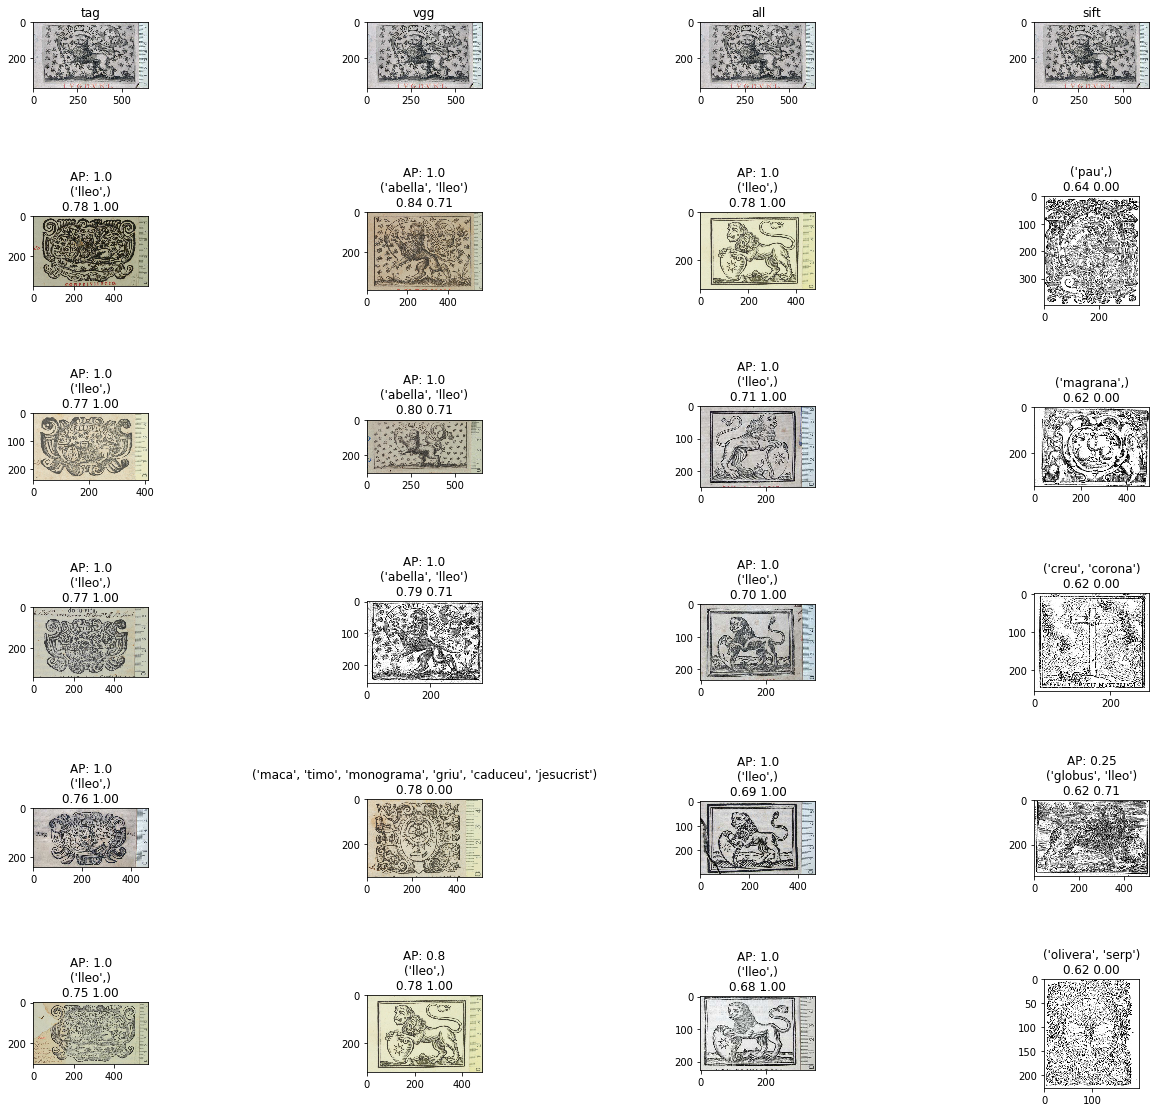

In [9]:
# En este ejemplo podemos ver la diferencia entre buscar por tags, vgg y al combinar ambos

show_similar_images(df, 123, 5)

query tags ('creu', 'cub', 'cor', 'ancora', 'serp', 'estrella', 'globus', 'griu', 'jupiter', 'aguila')
query tags 0000288c.jpg
Overall AP Function  tag 1.0
Overall AP Function  vgg 0.0
Overall AP Function  all 1.0
Overall AP Function  sift 0.0


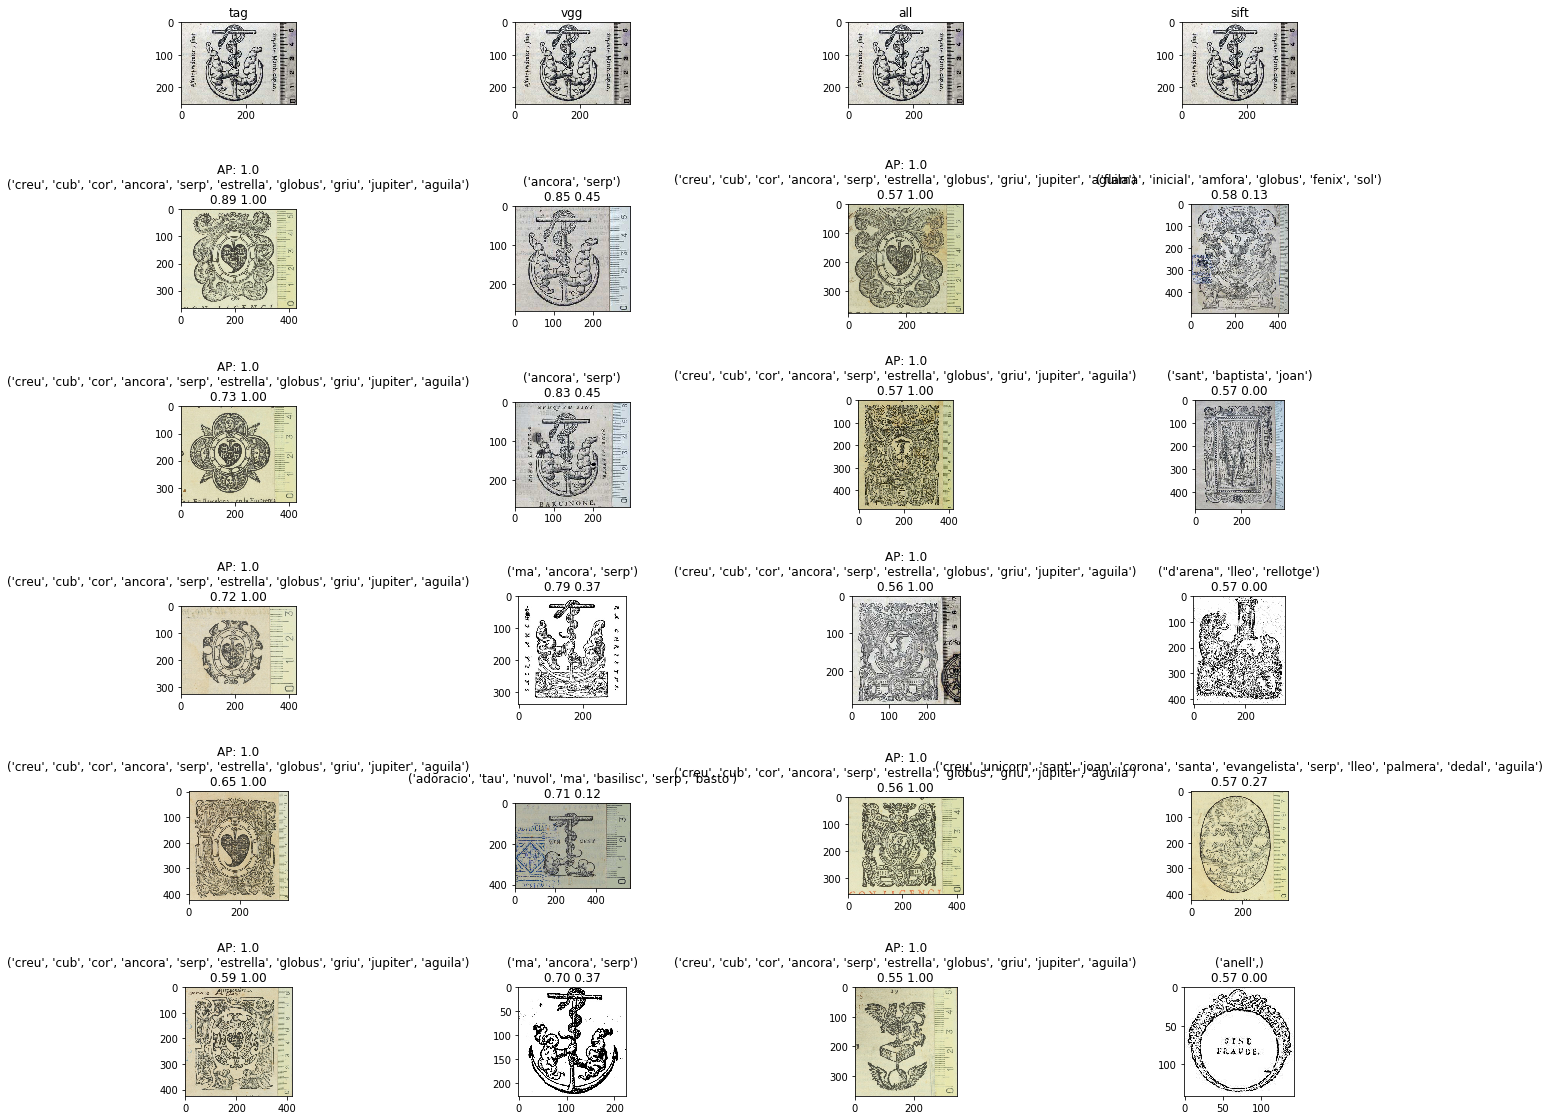

In [10]:
## En este ejemplo las tags de la query no representan al 100% la imagen, con lo cual VGG tiene un overall AP de 0 pero la simulitud es maxima

show_similar_images(df, 28, 5)

query tags ('esfera', 'hercules', 'temps')
query tags 0009492a.jpg
Overall AP Function  tag 0.8
Overall AP Function  vgg 0.2
Overall AP Function  all 0.6433333333333334
Overall AP Function  sift 0.0


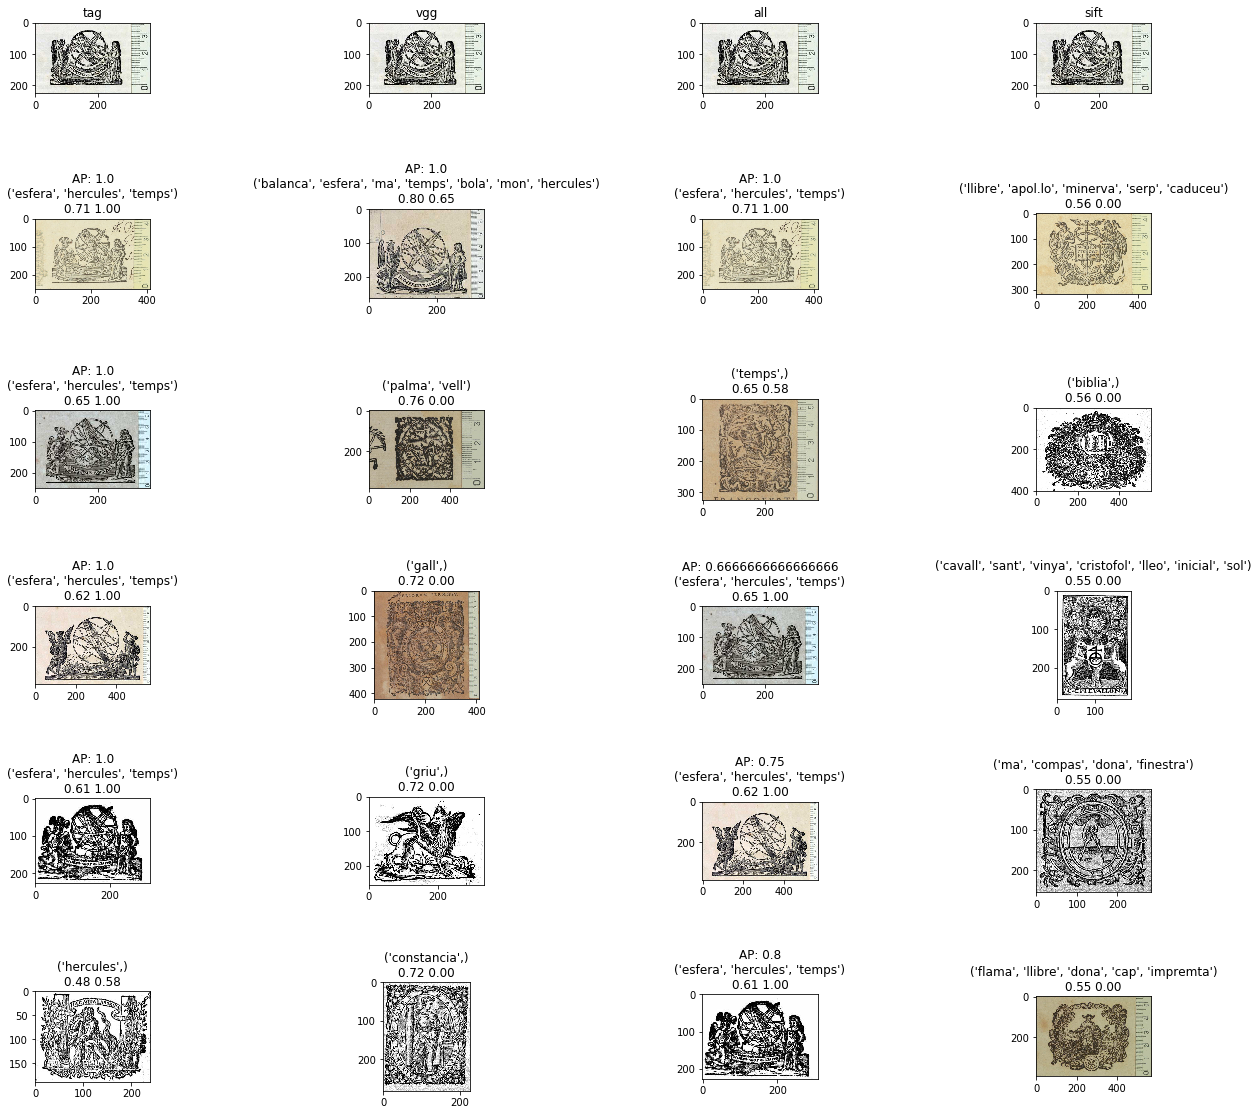

In [11]:
show_similar_images(df, 6, 5)

query tags ('heura', 'font', 'serp')
query tags 0009165a.jpg
Overall AP Function  tag 0.76
Overall AP Function  vgg 0.0
Overall AP Function  all 0.5433333333333333
Overall AP Function  sift 0.0


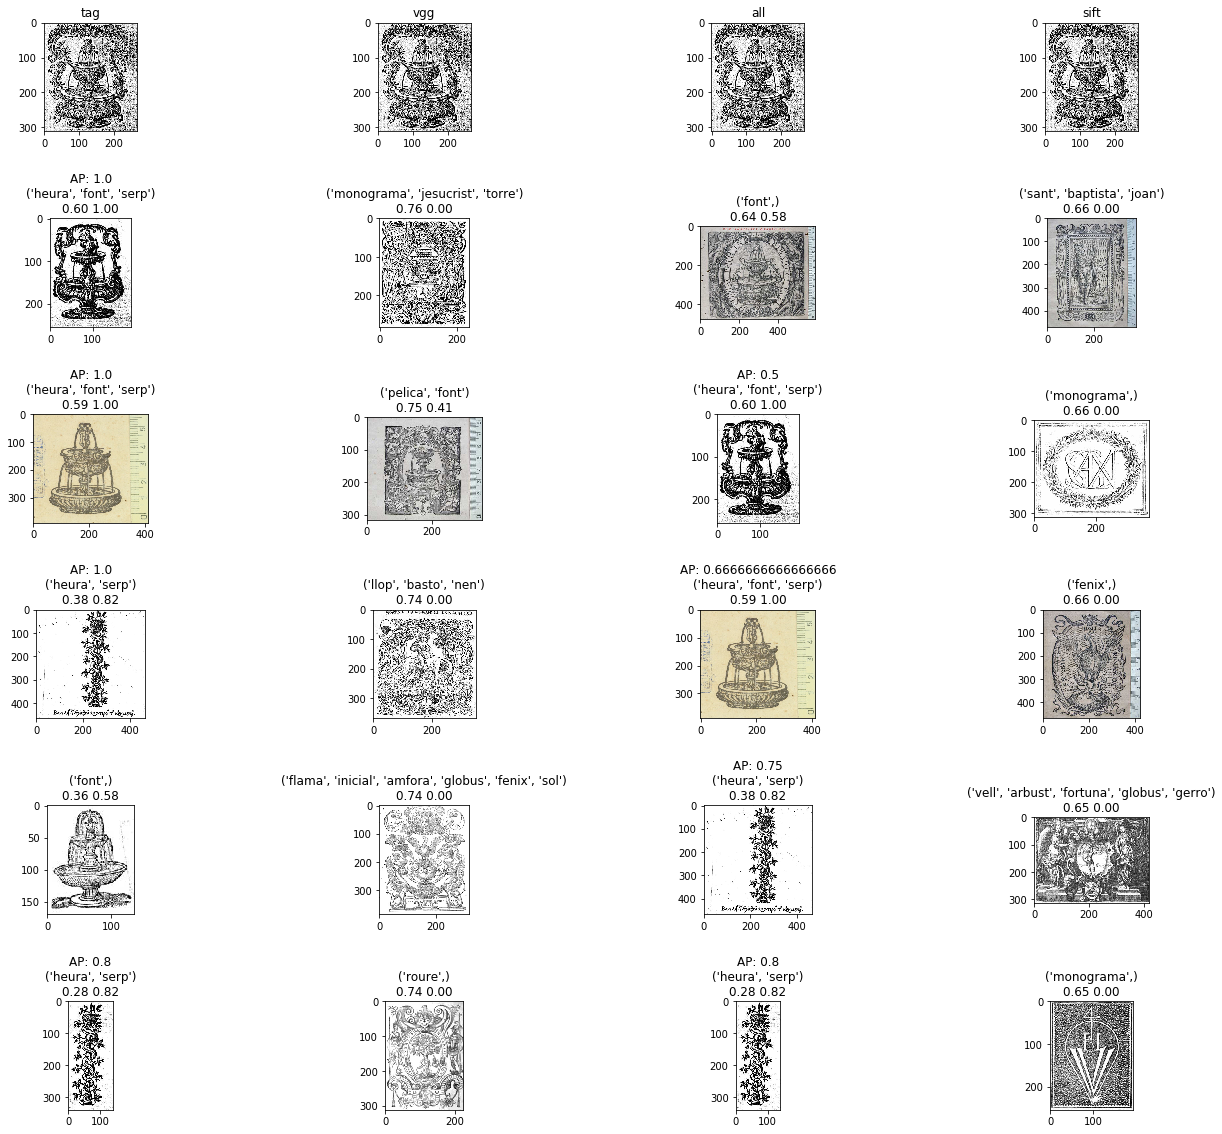

In [14]:
show_similar_images(df, 174, 5)

query tags ('ma', 'compas')
query tags 11602764f.jpg
Overall AP Function  tag 1.0
Overall AP Function  vgg 0.76
Overall AP Function  all 1.0
Overall AP Function  sift 0.0


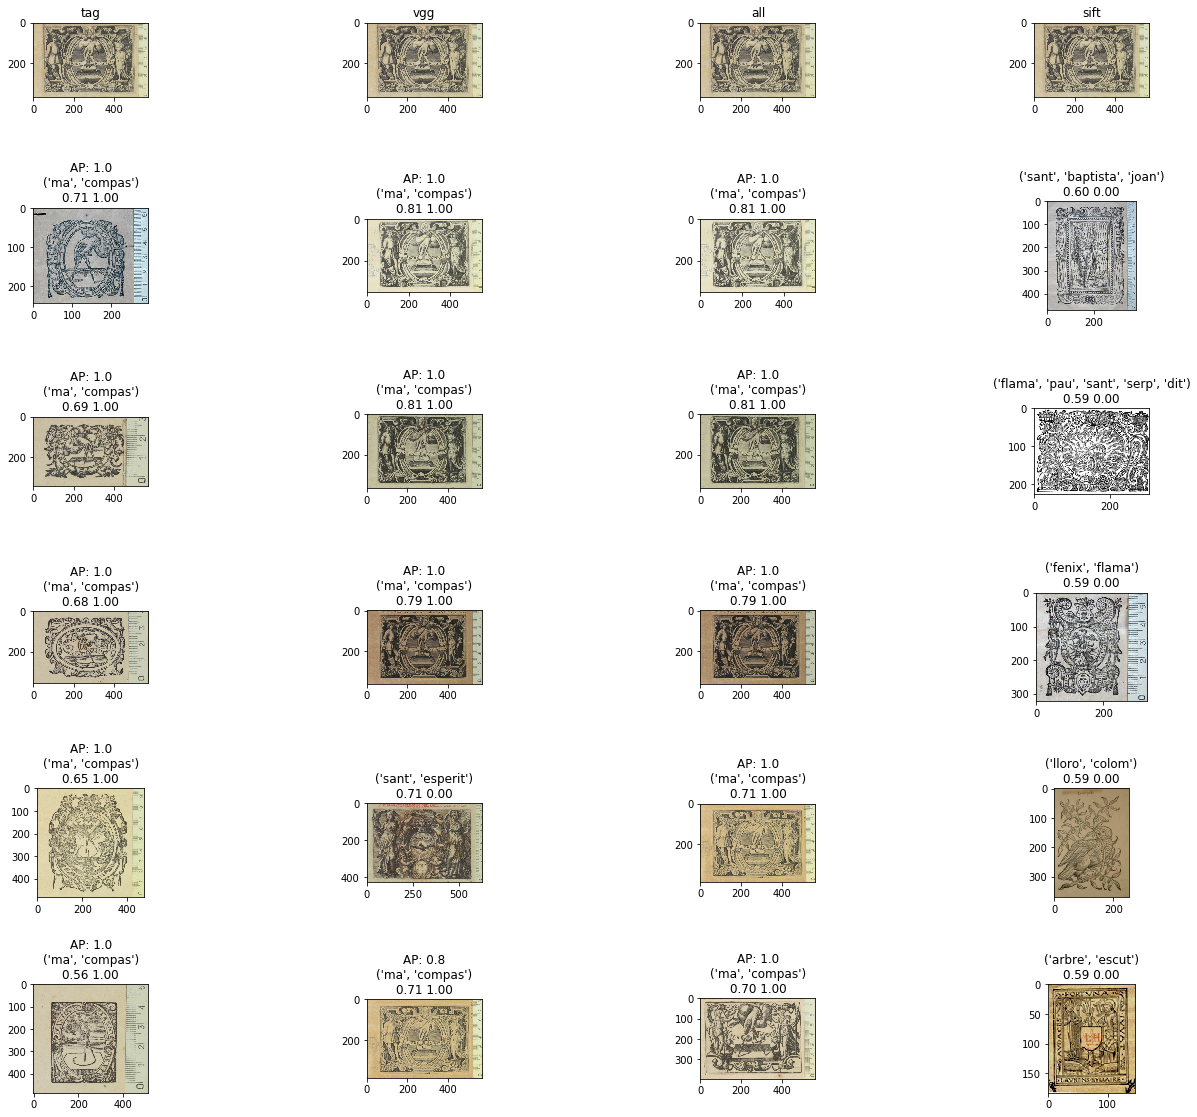

In [15]:
## En este ejemplo podemos ver que combinando VGG + Tags podemos observar que obtenemos imagenes del mismo tag con una simulitud mayor a la imagen query

show_similar_images(df, 162, 5)